In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

### KSS Dataset

In [2]:
import librosa

class KSSDataset(torch.utils.data.Dataset):
    def __init__(self, hparams, root_dir, meta_file, max_length):
        self.hparams = hparams
        self.data_files = self._get_data_files(root_dir, meta_file)
        self.max_length = max_length
        self.mel_matrix = librosa.filters.mel(sr=hparams.sampling_rate, 
                                              n_fft=hparams.win_length, 
                                              n_mels=hparams.n_mel_channels, 
                                              fmin=hparams.mel_fmin, 
                                              fmax=hparams.mel_fmax)
        
    def _get_data_files(self, root_dir, meta_file):
        meta_path = root_dir + meta_file
        data_files = []
        with open(meta_path, 'r') as f:
            l = f.readline().strip()
            while l:
                l = l.split('|')
                wav_file = l[0]
                wav_path = root_dir + 'kss/' + wav_file
                text = l[2]
                data_files.append((wav_path, text, wav_file))
                l = f.readline().strip()
                
        return data_files
    
    def _get_mel(self, wav_file):
        wav, _ = librosa.core.load(wav_file, sr=22050)
        wav, _ = librosa.effects.trim(wav, top_db=40)
        S = librosa.stft(wav, n_fft=self.hparams.win_length, hop_length=self.hparams.hop_length, 
                         win_length=self.hparams.win_length, window="hann", pad_mode="reflect")
        S = np.abs(S).T
        mel = S @ self.mel_matrix.T
        mel = np.log10(np.maximum(1e-5, mel))
        
        return mel.T
    
    def _get_utf8_values(self, text):
        text_utf = text.encode()
        ts = [0]
        for t in text_utf:
            ts.append(t)
        utf8_values = np.array(ts)
        
        return utf8_values
        
    def __getitem__(self, index):
        while True:
            audio = self._get_mel(self.data_files[index][0])
            if len(audio) > self.max_length:
                index = (index + 1) % self.__len__()
                continue
            text = self._get_utf8_values(self.data_files[index][1])
            break
        
        return torch.LongTensor(text), torch.FloatTensor(audio), self.data_files[index][2]
    
    def __len__(self):
        return len(self.data_files)


### TextMelCollate

In [3]:
class TextMelCollate():
    """ Zero-pads model inputs and targets based on number of frames per setep
    """
    def __init__(self, n_frames_per_step):
        self.n_frames_per_step = n_frames_per_step

    def __call__(self, batch):
        """Collate's training batch from normalized text and mel-spectrogram
        PARAMS
        ------
        batch: [text_normalized, mel_normalized]
        """
        # Right zero-pad all one-hot text sequences to max input length
        input_lengths, ids_sorted_decreasing = torch.sort(
            torch.LongTensor([len(x[0]) for x in batch]),
            dim=0, descending=True)
        max_input_len = input_lengths[0]

        text_padded = torch.LongTensor(len(batch), max_input_len)
        text_padded.zero_()
        for i in range(len(ids_sorted_decreasing)):
            text = batch[ids_sorted_decreasing[i]][0]
            text_padded[i, :text.size(0)] = text

        # Right zero-pad mel-spec
        num_mels = batch[0][1].size(0)
        max_target_len = max([x[1].size(1) for x in batch])
        if max_target_len % self.n_frames_per_step != 0:
            max_target_len += self.n_frames_per_step - max_target_len % self.n_frames_per_step
            assert max_target_len % self.n_frames_per_step == 0

        # include mel padded and gate padded
        mel_padded = torch.FloatTensor(len(batch), num_mels, max_target_len)
        mel_padded.zero_()
        gate_padded = torch.FloatTensor(len(batch), max_target_len)
        gate_padded.zero_()
        output_lengths = torch.LongTensor(len(batch))
        wav_files = []
        for i in range(len(ids_sorted_decreasing)):
            mel = batch[ids_sorted_decreasing[i]][1]
            mel_padded[i, :, :mel.size(1)] = mel
            gate_padded[i, mel.size(1)-1:] = 1
            output_lengths[i] = mel.size(1)
            wav_files.append(batch[ids_sorted_decreasing[i]][2])

        return text_padded, input_lengths, mel_padded, gate_padded, output_lengths, wav_files
    

### Read KSSDataset

In [4]:
from torch.utils.data import DataLoader
from hparams import hparams

dataset = KSSDataset(hparams=hparams, root_dir='kss_dataset/', meta_file='transcript.v.1.4.txt', max_length=1024)
train_loader = DataLoader(dataset, num_workers=1, shuffle=False, batch_size=4, collate_fn=TextMelCollate(n_frames_per_step=1))
print(train_loader)

for batch in train_loader:
    text_padded, input_lengths, mel_padded, gate_padded, output_lengths, wave_files = batch
    print(text_padded.shape)
    print(input_lengths.shape)
    print(mel_padded.shape)
    print(gate_padded.shape)
    print(output_lengths.shape)
    print(wave_files)
    break

torch.Size([4, 64])
torch.Size([4])
torch.Size([4, 80, 317])
torch.Size([4, 317])
torch.Size([4])
['1/1_0001.wav', '1/1_0000.wav', '1/1_0003.wav', '1/1_0002.wav']


### Text Padded

In [5]:
for text, input_length in zip(text_padded, input_lengths):
    print(input_length, text)

tensor(64) tensor([  0, 234, 183, 184, 235, 133, 128, 236, 157, 152,  32, 236, 130, 172,
        235, 158, 145, 236, 157, 132,  32, 236, 150, 187, 234, 184, 176,  32,
        236, 156, 132, 237, 149, 180,  32, 236, 149, 160, 236, 141, 188, 236,
        167, 128, 235, 167, 140,  32, 237, 151, 155, 236, 136, 152, 234, 179,
        160, 236, 152, 128, 235, 139, 164,  46])
tensor(55) tensor([  0, 234, 183, 184, 235, 138, 148,  32, 234, 180, 156, 236, 176, 174,
        236, 157, 128,  32, 236, 178, 153, 237, 149, 152, 235, 160, 164, 234,
        179, 160,  32, 236, 149, 160, 236, 147, 176, 235, 138, 148,  32, 234,
        178, 131,  32, 234, 176, 153, 236, 149, 152, 235, 139, 164,  46,   0,
          0,   0,   0,   0,   0,   0,   0,   0])
tensor(35) tensor([  0, 234, 183, 184, 235, 138, 148,  32, 236, 149, 132, 235, 130, 180,
        235, 165, 188,  32, 235, 167, 142, 236, 157, 180,  32, 236, 149, 132,
        235, 130, 128, 235, 139, 164,  46,   0,   0,   0,   0,   0,   0,   0,
          0

### Show mel, gate data

Mel shape : torch.Size([80, 317]) Gate shape : torch.Size([317])
Output length : tensor(317)


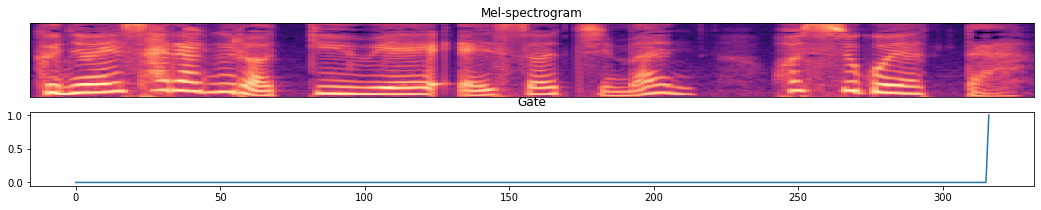

Mel shape : torch.Size([80, 317]) Gate shape : torch.Size([317])
Output length : tensor(283)


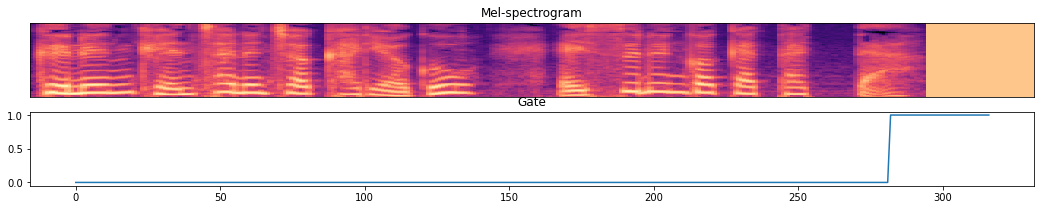

Mel shape : torch.Size([80, 317]) Gate shape : torch.Size([317])
Output length : tensor(189)


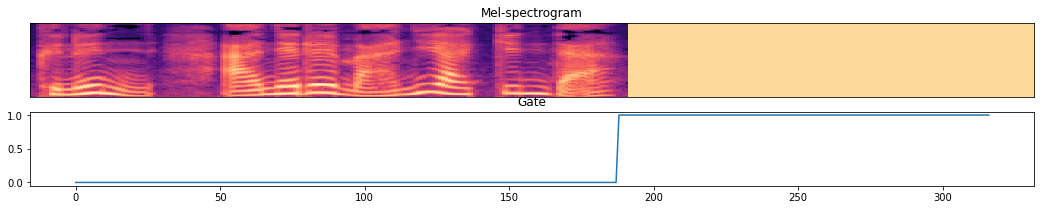

Mel shape : torch.Size([80, 317]) Gate shape : torch.Size([317])
Output length : tensor(149)


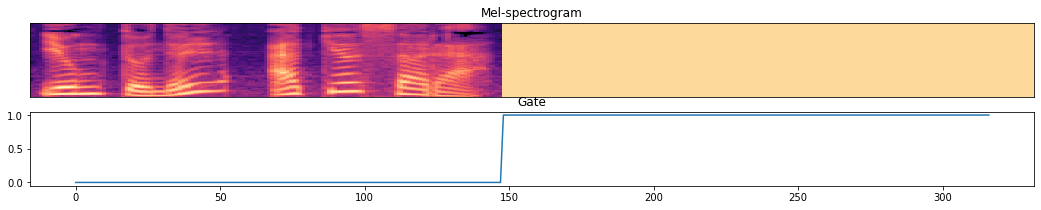

In [6]:
import matplotlib.pyplot as plt
import librosa.display

for mel, gate, output_length in zip(mel_padded, gate_padded, output_lengths):
    print('Mel shape :', mel.shape, 'Gate shape :', gate.shape)
    
    _mel = mel.data.cpu().numpy()
    _gate = gate.data.cpu().numpy()
    
    print('Output length :', output_length)
    plt.figure(figsize=[18, 3])
    plt.subplot(2, 1, 1)
    plt.title('Mel-spectrogram')
    librosa.display.specshow(_mel)
    plt.subplot(2, 1, 2)
    plt.title('Gate')
    plt.plot(_gate)
    plt.show()